_This notebook contains code and comments from Section 3.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 3.4 Case Study: Sentiment Analysis

Sentiment analysis is a natural language processing (NLP) task for identifying the the polarity of opinion as positive, neutral or negative. This case study explores a supervised sentiment analysis task for movie reviews. The data set we will use is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which was originally collected and curated for a 2011 paper on sentiment analysis: 

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). _Learning Word Vectors for Sentiment Analysis_. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

In [1]:
# Data directory relative to this notebook
sentiment_data_directory = './data/ch03/'

### 3.4.1 Pre-processing
This data set has already been pre-processed by [count vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to generate [bag-of-word features](https://en.wikipedia.org/wiki/Bag-of-words_model). These pre-processed term-document count features, our data set, can be found in ``./data/ch03/train/labeledBow.feat`` and ``./data/ch03/test/labeledBow.feat``.

#### Stop-word Removal
This step aims to remove common words such as “the”, “is”, “a”, “an”. Stop word removal can reduce the dimensionality of the data, (to make processing faster), and can improve classification performance. This is because words like “the” are often not really informative for information retrieval and text-mining tasks.

**Listing 3.11**: Drop stop words from the vocabulary

In [2]:
import nltk
import time
import numpy as np

def prune_vocabulary(data_path, max_features=5000):
    start_time = time.time()
    with open('{0}/imdb.vocab'.format(data_path), 'r', encoding='utf8') as vocab_file:
        vocabulary = vocab_file.read().splitlines()
    print('Vocabulary load time = {0} seconds.'.format(time.time() - start_time))

    # Convert the list of stopwords to a set for faster processing
    # nltk.download('stopwords')
    stopwords = set(nltk.corpus.stopwords.words("english"))

    # Keep only those vocabulary words that are NOT stopwords
    to_keep = [True if word not in stopwords else False for word in vocabulary]
    feature_ind = np.where(to_keep)[0]

    return feature_ind[:max_features]

In [3]:
features = prune_vocabulary(sentiment_data_directory, max_features=5000)

Vocabulary load time = 0.016955852508544922 seconds.


#### TF-IDF Transformation
Our second pre-processing step converts the count features to [tf-idf features](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). These features represent the term frequency-inverse document frequency, a statistic that weights each feature in a document (in our case, a single review) relative to how often it appears in that document as well as how often it appears in the entire corpus (in our case, all the reviews). 

We can use scikit-learn’s pre-processing toolbox to convert our count features to tf-idf features using the [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

**Listing 3.12**: Extract tf-idf features and save the data set (**NOTE: _generates a 41 MB file_**)

In [4]:
import h5py
from sklearn.datasets import load_svmlight_files
from scipy.sparse import csr_matrix as sp
from sklearn.feature_extraction.text import TfidfTransformer

def preprocess_and_save(data_path, feature_ind):
    data_files = ['{0}/{1}/labeledBow.feat'.format(data_path, data_set) 
                  for data_set in ['train', 'test']]
    [Xtrn, ytrn, Xtst, ytst] = load_svmlight_files(data_files)
    n_features = len(feature_ind)

    ytrn[ytrn <= 5], ytst[ytst <= 5] = 0, 0
    ytrn[ytrn > 5], ytst[ytst > 5] = 1, 1

    # Transform the bag-of-words
    tfidf = TfidfTransformer()
    Xtrn = tfidf.fit_transform(Xtrn[:, feature_ind])
    Xtst = tfidf.transform(Xtst[:, feature_ind])
      
    # Save the data in HDF5 format with sparse matrix representation
    with h5py.File('{0}/imdb-{1}k.h5'.format(data_path, 
                            round(n_features/1000)), 'w') as db:
        db.create_dataset('Xtrn', 
                          data=sp.todense(Xtrn), compression='gzip')
        db.create_dataset('ytrn', data=ytrn, compression='gzip')
        db.create_dataset('Xtst', 
                          data=sp.todense(Xtst), compression='gzip')
        db.create_dataset('ytst', data=ytst, compression='gzip')

In [5]:
preprocess_and_save(sentiment_data_directory, features)

---
### 3.4.2	Dimensionality Reduction

We adopt the popular dimensionality reduction approach of [principal components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA), which aims to compress and embed the data into a lower-dimensional representation while while preserving as much of the information as possible. 

To avoid loading the entire data set into memory and to process the data more efficiently, we perform [Incremental PCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html) instead.

**Listing 3.13**: Perform dimensionality reduction using Incremental PCA (**NOTE: _generates a 187 MB file_**)

In [6]:
from sklearn.decomposition import IncrementalPCA

def transform_sentiment_data(data_path, n_features=5000, n_components=500):
    db = h5py.File('{0}/imdb-{1}k.h5'.format(data_path, round(n_features/1000)), 'r')

    pca = IncrementalPCA(n_components=n_components)
    chunk_size = 1000
    n_samples = db['Xtrn'].shape[0] 
    for i in range(0, n_samples // chunk_size):
        pca.partial_fit(db['Xtrn'][i*chunk_size:(i+1) * chunk_size])

    Xtrn = pca.transform(db['Xtrn'])
    Xtst = pca.transform(db['Xtst'])

    with h5py.File('{0}/imdb-{1}k-pca{2}.h5'.format(data_path,
                                                    round(n_features/1000), n_components), 'w') as db2:
        db2.create_dataset('Xtrn', data=Xtrn, compression='gzip')
        db2.create_dataset('ytrn', data=db['ytrn'], compression='gzip')
        db2.create_dataset('Xtst', data=Xtst, compression='gzip')
        db2.create_dataset('ytst', data=db['ytst'], compression='gzip')

In [7]:
transform_sentiment_data(sentiment_data_directory, n_features=5000, n_components=500)

---
###  3.4.3	Stacking classifiers

Our goal now is to train a heterogeneous ensemble with meta-learning. Specifically, we will use ensemble several base estimators by blending them. Blending is a variant of stacking, where, instead of using cross validation, we use a single validation set.

In [8]:
def load_sentiment_data(data_path,n_features=5000, n_components=500):

    with h5py.File('{0}/imdb-{1}k-pca{2}.h5'.format(data_path, 
                                                    round(n_features/1000), n_components), 'r') as db:
        Xtrn = np.array(db.get('Xtrn'))
        ytrn = np.array(db.get('ytrn'))
        Xtst = np.array(db.get('Xtst'))
        ytst = np.array(db.get('ytst'))

    return Xtrn, ytrn, Xtst, ytst

In [9]:
Xtrn, ytrn, Xtst, ytst = load_sentiment_data('./data/Ch03/', n_features=5000, n_components=500)

Next, we use five base estimators: [``RandomForestClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with 100 randomized decision trees, [``ExtraTreesClassifier``] (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) with 100 extremely randomized trees, [``Logistic Regression``](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), Bernoulli [naïve Bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) (``BernoulliNB``) and a linear SVM trained with stochastic gradient descent ([``SGDClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)).

In [10]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB

estimators = [('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1)),
              ('xt', ExtraTreesClassifier(n_estimators=100, n_jobs=-1)),
              ('lr', LogisticRegression(C=0.01, solver='lbfgs')),
              ('bnb', BernoulliNB()),
              ('svm', SGDClassifier(loss='hinge', penalty='l2', alpha=0.01,
                                    n_jobs=-1, max_iter=10, tol=None))]

To blend these base-estimators into a heterogeneous ensemble with meta-learning, we use the following procedure:
1.	Split the training data into a training set ``(Xtrn, ytrn)`` with 80% of the data and a validation set ``(Xval, yval)``, with the remaining 20% of the data
2.	Train the each of the level-1 estimators on the training set, ``(Xtrn, ytrn)``
3.	Generate meta-features ``Xmeta`` with the trained estimators using ``Xval``; 
4.	Augment the validation data with the meta-features: ``[Xval, Xmeta]``; this augmented validation set will have 500 original features + 5 meta-features
5.	Train the level-2 estimator with the augmented validation set ``([Xval, Xmeta], yval)``

This leaves one final decision: the choice of the level-2 estimator. Previously, we used simple linear classifiers. For this classification task, we utilize a neural network. 

In [11]:
from sklearn.neural_network import MLPClassifier
meta_estimator = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                               alpha=0.001)

**Listing 3.14**: Blending models with a validation set

In [12]:
from sklearn.model_selection import train_test_split

def blend_models(level1_estimators, level2_estimator, 
                 X, y , use_probabilities=False):    
    Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.2)

    n_estimators = len(level1_estimators)
    n_samples = len(yval)
    Xmeta = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(level1_estimators):
        estimator.fit(Xtrn, ytrn)
        Xmeta[:, i] = estimator.predict(Xval)

    Xmeta = np.hstack([Xval, Xmeta])
    
    level2_estimator.fit(Xmeta, yval)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}

    return final_model

**Listing 3.2** for individual base estimator predictions and **Listing 3.9** for meta-estimator predictions are combined here.

In [13]:
def predict_stacking(X, stacked_model):
    # Get level-1 predictions
    level1_estimators = stacked_model['level-1']
    n_samples, n_estimators = X.shape[0], len(level1_estimators)
    use_probabilities = stacked_model['use-proba']

    Xmeta = np.zeros((n_samples, n_estimators))  # Initialize meta-features
    for i, (model, estimator) in enumerate(level1_estimators):
        if use_probabilities:
            Xmeta[:, i] = estimator.predict_proba(X)[:, 1]
        else:
            Xmeta[:, i] = estimator.predict(X)

    level2_estimator = stacked_model['level-2']
    Xmeta = np.hstack([X, Xmeta])

    y = level2_estimator.predict(Xmeta)

    return y

Train a simple blending model with this code:

In [14]:
stacked_model = blend_models(estimators, meta_estimator, Xtrn, ytrn)

In [15]:
from sklearn.metrics import accuracy_score

ypred = predict_stacking(Xtrn, stacked_model)
trn_err = (1 - accuracy_score(ytrn, ypred)) * 100
print(trn_err)

ypred = predict_stacking(Xtst, stacked_model)
tst_err = (1 - accuracy_score(ytst, ypred)) * 100
print(tst_err)

7.8359999999999985
17.196


---

### Overall Performance of the blended model
We finally visualize and comparing the performance of each individual base classifier with the meta-classifier ensemble. Stacking/blending improves classification performance by ensembling diverse base classifiers.

In [16]:
trn_errors, tst_errors = np.zeros((len(estimators) + 1, )), np.zeros((len(estimators) + 1, ))
for i, (method, estimator) in enumerate(estimators):
    start_time = time.clock()
    estimator.fit(Xtrn, ytrn)
    run_time = time.clock() - start_time

    ypred = estimator.predict(Xtrn)
    trn_errors[i] = (1 - accuracy_score(ytrn, ypred)) * 100
    ypred = estimator.predict(Xtst)
    tst_errors[i] = (1 - accuracy_score(ytst, ypred)) * 100

    print('{0}: training error = {1:4.2f}%, test error = {2:4.2f}%, running time = {3:4.2f} seconds.'
          .format(method, trn_errors[i], tst_errors[i], run_time))
    
trn_errors[-1] = trn_err
tst_errors[-1] = tst_err

rf: training error = 0.00%, test error = 22.61%, running time = 10.22 seconds.
xt: training error = 0.00%, test error = 30.00%, running time = 4.44 seconds.
lr: training error = 17.65%, test error = 18.03%, running time = 0.13 seconds.
bnb: training error = 21.66%, test error = 22.84%, running time = 0.35 seconds.
svm: training error = 22.84%, test error = 23.05%, running time = 0.41 seconds.


In [17]:
import matplotlib.pyplot as plt
def autolabel(ax, rects):
    for rect in rects:
        height = np.round(rect.get_height(), 1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

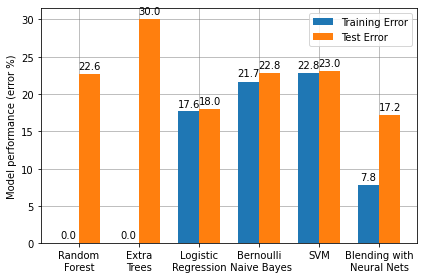

In [18]:
%matplotlib inline

labels = ['Random\nForest', 'Extra\nTrees', 'Logistic\nRegression', 
      'Bernoulli\n Naive Bayes', 'SVM', 'Blending with\nNeural Nets']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, trn_errors, width, label='Training Error')
rects2 = ax.bar(x + width / 2, tst_errors, width, label='Test Error')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model performance (error %)')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

autolabel(ax, rects1)
autolabel(ax, rects2)

fig.tight_layout()
plt.savefig('./figures/CH03_F19_Kunapuli.png', dpi=300, bbox_inches='tight', pad_inches=0)